In [8]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as python_random

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import regularizers

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle) # if there's an "SavedModel file does not exist at:", delete that folder and rerun it

In [2]:
df_all = pd.read_csv('../train_val_test_sgkf_Feb24.csv', index_col=0)
df_all

,file,source,category,weight,file_group,fold
0,../data/interim/SONYC/audio-4/00_017389.pkl,city_SONYC,1,0.000433,../data/interim/SONYC/audio-4/00_017389.pkl,7
1,../data/interim/SONYC/audio-13/01_017897.pkl,city_SONYC,1,0.000433,../data/interim/SONYC/audio-13/01_017897.pkl,6
2,../data/interim/youtube/NatureSoundscapes/YVwx...,nature_youtube/NatureSoundscapes,0,0.000479,youtube/NatureSoundscapes/YVwx7YTmRbM,0
3,../data/interim/youtube/NatureSoundscapes/kHJl...,nature_youtube/NatureSoundscapes,0,0.000479,youtube/NatureSoundscapes/kHJlGDCwd9k,3
4,../data/interim/SONYC/audio-16/20_017610.pkl,city_SONYC,1,0.000433,../data/interim/SONYC/audio-16/20_017610.pkl,4
...,...,...,...,...,...,...
5677,../data/interim/S2L_LULC/urban_0_25/s2lam029_2...,nature_S2L_LULC,0,0.002083,../data/interim/S2L_LULC/urban_0_25/s2lam029_2...,8
5678,../data/interim/youtube/NomadicAmbience_nature...,nature_youtube/NomadicAmbience_nature,0,0.005714,youtube/NomadicAmbience_nature/B0mtZyMMhZI,2
5679,../data/interim/SONYC/audio-1/01_009080.pkl,city_SONYC,1,0.000433,../data/interim/SONYC/audio-1/01_009080.pkl,9
5680,../data/interim/youtube/NatureSoundscapes/xPQy...,nature_youtube/NatureSoundscapes,0,0.000479,youtube/NatureSoundscapes/xPQy66ZcHdY,8


# Convert data into TF format

In [3]:
def load_wav_pkl(filename, wav_label='y'):
    import pickle
    # open a file, where you stored the pickled data
    file = open(filename, 'rb')

    # dump information to that file
    output = pickle.load(file)
    wav = output[wav_label]

    # close the file
    file.close()
    return wav

wav_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'])) == 160000:
        wav_list.append(load_wav_pkl(row['file']))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'])
        print('short length: '+str(len(temp_wav)))
        wav_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

wav_bg_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'], 'bg_y')) == 160000:
        wav_bg_list.append(load_wav_pkl(row['file'], 'bg_y'))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'], 'bg_y')
#         print('short length: '+str(len(temp_wav)))
        wav_bg_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

wav_fg_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'], 'fg_y')) == 160000:
        wav_fg_list.append(load_wav_pkl(row['file'], 'fg_y'))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'], 'fg_y')
#         print('short length: '+str(len(temp_wav)))
        wav_fg_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

short length: 151461
short length: 148006
short length: 159999
short length: 153242
short length: 159880
short length: 151683
short length: 159880
short length: 159997
short length: 146099
short length: 159880
short length: 157848
short length: 159993
short length: 156480
short length: 159880
short length: 159992
short length: 153357
short length: 67456


In [4]:
main_ds = tf.data.Dataset.from_tensor_slices((np.stack(wav_list, axis = 0), df_all['category'], df_all['fold'], df_all['weight']))
main_ds_fg = tf.data.Dataset.from_tensor_slices((np.stack(wav_fg_list, axis = 0), df_all['category'], df_all['fold'], df_all['weight']))
main_ds_bg = tf.data.Dataset.from_tensor_slices((np.stack(wav_bg_list, axis = 0), df_all['category'], df_all['fold'], df_all['weight']))


# applies the embedding extraction model to a wav data
def extract_embedding_weight(wav_data, label, fold, weight):
    # run YAMNet to extract embedding from the wav data
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings),
            tf.repeat(weight, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding_weight).unbatch()
main_ds_fg = main_ds_fg.map(extract_embedding_weight).unbatch()
main_ds_bg = main_ds_bg.map(extract_embedding_weight).unbatch()

In [5]:
def split_ds(main_ds):
    cached_ds = main_ds.cache()
    train_ds = cached_ds.filter(lambda embedding, label, fold, weight: fold < 8)
    val_ds = cached_ds.filter(lambda embedding, label, fold, weight: fold == 8)
    test_ds = cached_ds.filter(lambda embedding, label, fold, weight: fold == 9)

    # remove the folds column now that it's not needed anymore
    remove_fold_column = lambda embedding, label, fold, weight: (embedding, label, weight)

    train_ds = train_ds.map(remove_fold_column)
    val_ds = val_ds.map(remove_fold_column)
    test_ds = test_ds.map(remove_fold_column)

    train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = split_ds(main_ds)
train_ds_bg, val_ds_bg, test_ds_bg = split_ds(main_ds_bg)
train_ds_fg, val_ds_fg, test_ds_fg = split_ds(main_ds_fg)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Shared model parameters

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
my_classes = ['city', 'nature']
Sequential_model = [tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
                    tf.keras.layers.Dropout(.5),
                    tf.keras.layers.Dense(256, activation='relu'),
                    tf.keras.layers.Dropout(.5),
                    tf.keras.layers.Dense(len(my_classes))
                    ]

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

# Model of raw signal

In [60]:
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)

raw_model = tf.keras.Sequential(Sequential_model, name='raw_model')

raw_model.summary()

Model: "raw_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 262,914
Trainable params: 262,914
Non-trainable params: 0
_________________________________________________________________


In [61]:
raw_model.compile(loss=loss_func,
                  optimizer=optimizer,
                  weighted_metrics=[],
                  metrics=['accuracy'])


history_raw = raw_model.fit(train_ds,
                            epochs=20,
                            validation_data=val_ds,
                            callbacks=callback)

Epoch 1/20
2848/2848 [==============================] - 8s 3ms/step - loss: 0.0012 - accuracy: 0.8224 - val_loss: 0.0013 - val_accuracy: 0.7681
Epoch 2/20
2848/2848 [==============================] - 8s 3ms/step - loss: 0.0010 - accuracy: 0.8336 - val_loss: 0.0012 - val_accuracy: 0.8084
Epoch 3/20
2848/2848 [==============================] - 8s 3ms/step - loss: 0.0010 - accuracy: 0.8399 - val_loss: 0.0014 - val_accuracy: 0.8009
Epoch 4/20
2848/2848 [==============================] - 8s 3ms/step - loss: 0.0011 - accuracy: 0.8418 - val_loss: 0.0013 - val_accuracy: 0.8227
Epoch 5/20
2848/2848 [==============================] - 9s 3ms/step - loss: 9.6198e-04 - accuracy: 0.8435 - val_loss: 0.0013 - val_accuracy: 0.8236
Epoch 6/20
2848/2848 [==============================] - 8s 3ms/step - loss: 9.7700e-04 - accuracy: 0.8442 - val_loss: 0.0013 - val_accuracy: 0.8135
Epoch 7/20
2848/2848 [==============================] - 8s 3ms/step - loss: 9.5218e-04 - accuracy: 0.8451 - val_loss: 0.0013 - v

In [62]:
# this is the accuracy per YAMNet sample, not the accuracy per audio file
loss, accuracy = raw_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

353/353 [==============================] - 1s 2ms/step - loss: 0.0011 - accuracy: 0.8584
Loss:  0.001137984567321837
Accuracy:  0.8584219813346863


In [63]:
def acc_by_audio(model, test_ds, y_true):
    n_sample_per_audio = 20
    y_pred = model.predict(test_ds)
    y_reshaped = y_pred.reshape(-1, n_sample_per_audio, 2) # reshape to audio*sample*binary_prediction
    y_pred_by_row = y_reshaped.mean(axis=1).argmax(axis=1)
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_true, y_pred_by_row), y_pred_by_row


In [64]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(raw_model, test_ds, y_true = test_df['category'])
print(acc)

353/353 [==============================] - 0s 1ms/step
0.900709219858156


/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_83135/3143404827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


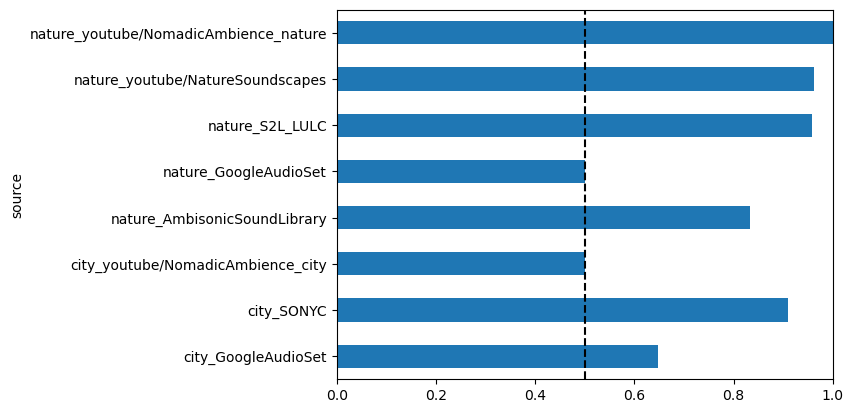

In [65]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Model of background signal

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)

bg_model = tf.keras.Sequential(Sequential_model, name='bg_model')

bg_model.summary()

Model: "bg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 262,914
Trainable params: 262,914
Non-trainable params: 0
_________________________________________________________________


In [15]:
bg_model.compile(loss=loss_func,
                 optimizer=optimizer,
                 weighted_metrics=[],
                 metrics=['accuracy'])


history_bg =bg_model.fit(train_ds_bg,
                         epochs=20,
                         validation_data=val_ds_bg,
                         callbacks=callback)

Epoch 1/20
2848/2848 [==============================] - 411s 142ms/step - loss: 9.4412e-04 - accuracy: 0.8550 - val_loss: 0.0013 - val_accuracy: 0.8609
Epoch 2/20
2848/2848 [==============================] - 8s 3ms/step - loss: 9.2145e-04 - accuracy: 0.8577 - val_loss: 0.0013 - val_accuracy: 0.8430
Epoch 3/20
2848/2848 [==============================] - 8s 3ms/step - loss: 9.2070e-04 - accuracy: 0.8544 - val_loss: 0.0013 - val_accuracy: 0.8509
Epoch 4/20
2848/2848 [==============================] - 8s 3ms/step - loss: 9.2295e-04 - accuracy: 0.8594 - val_loss: 0.0013 - val_accuracy: 0.8575
Epoch 5/20
2848/2848 [==============================] - 8s 3ms/step - loss: 9.1640e-04 - accuracy: 0.8578 - val_loss: 0.0013 - val_accuracy: 0.8623
Epoch 6/20
2848/2848 [==============================] - 8s 3ms/step - loss: 9.2920e-04 - accuracy: 0.8588 - val_loss: 0.0013 - val_accuracy: 0.8619
Epoch 7/20
2848/2848 [==============================] - 8s 3ms/step - loss: 9.0028e-04 - accuracy: 0.8572 - 

In [16]:
loss, accuracy = bg_model.evaluate(test_ds_bg)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

353/353 [==============================] - 4s 6ms/step - loss: 0.0011 - accuracy: 0.8707
Loss:  0.0011409256840124726
Accuracy:  0.8707447052001953


In [17]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(bg_model, test_ds_bg, y_true = test_df['category'])
print(acc)

353/353 [==============================] - 0s 973us/step
0.9202127659574468


/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_48340/3143404827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


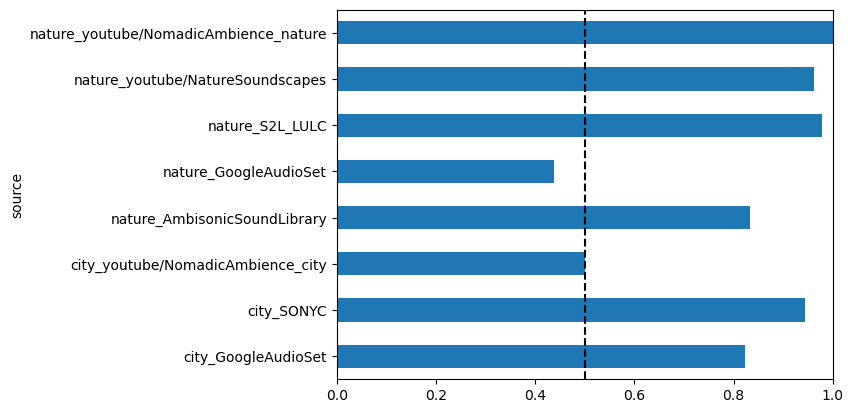

In [18]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Model of foreground signal

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)

fg_model = tf.keras.Sequential(Sequential_model, name='fg_model')

fg_model.summary()

Model: "fg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 262,914
Trainable params: 262,914
Non-trainable params: 0
_________________________________________________________________


In [20]:
fg_model.compile(loss=loss_func,
                 optimizer=optimizer,
                 weighted_metrics=[],
                 metrics=['accuracy'])


history_fg =fg_model.fit(train_ds_fg,
                         epochs=20,
                         validation_data=val_ds_fg,
                         callbacks=callback)

Epoch 1/20
2848/2848 [==============================] - 421s 146ms/step - loss: 0.0014 - accuracy: 0.5918 - val_loss: 0.0013 - val_accuracy: 0.5908
Epoch 2/20
2848/2848 [==============================] - 8s 3ms/step - loss: 0.0013 - accuracy: 0.5960 - val_loss: 0.0014 - val_accuracy: 0.6014
Epoch 3/20
2848/2848 [==============================] - 8s 3ms/step - loss: 0.0013 - accuracy: 0.5972 - val_loss: 0.0013 - val_accuracy: 0.6210
Epoch 4/20
2848/2848 [==============================] - 8s 3ms/step - loss: 0.0013 - accuracy: 0.6071 - val_loss: 0.0014 - val_accuracy: 0.6105
Epoch 5/20
2848/2848 [==============================] - 8s 3ms/step - loss: 0.0013 - accuracy: 0.6075 - val_loss: 0.0013 - val_accuracy: 0.6206
Epoch 6/20
2848/2848 [==============================] - 8s 3ms/step - loss: 0.0013 - accuracy: 0.6105 - val_loss: 0.0013 - val_accuracy: 0.6335
Epoch 7/20
2848/2848 [==============================] - 9s 3ms/step - loss: 0.0013 - accuracy: 0.6147 - val_loss: 0.0013 - val_accur

In [21]:
loss, accuracy = fg_model.evaluate(test_ds_fg)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

353/353 [==============================] - 6s 7ms/step - loss: 0.0014 - accuracy: 0.6520
Loss:  0.0013729247730225325
Accuracy:  0.6520389914512634


In [22]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(fg_model, test_ds_fg, y_true = test_df['category'])
print(acc)

353/353 [==============================] - 0s 1ms/step
0.6879432624113475


/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_48340/3143404827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


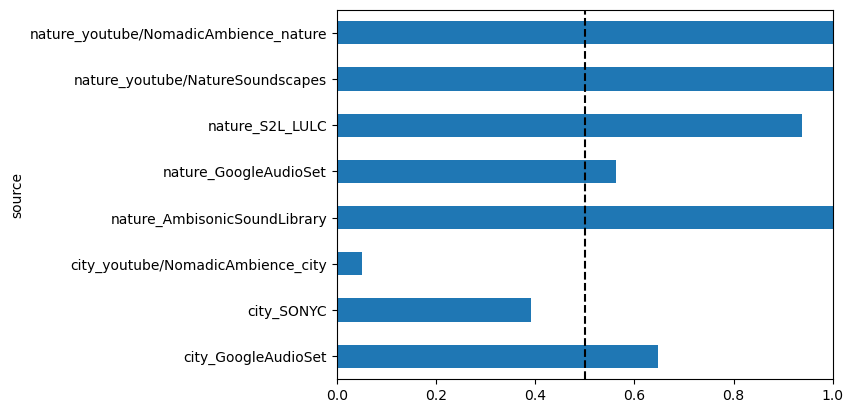

In [23]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()